# Heritability Analysis


As an application of the variance component model, this note demonstrates the workflow for heritability analysis in genetics, using a sample data set `cg10k` with **6,670** individuals and **630,860** SNPs. Person IDs and phenotype names are masked for privacy. `cg10k.bed`, `cg10k.bim`, and `cg10k.fam` is a set of Plink files in binary format. `cg10k_traits.txt` contains 13 phenotypes of the 6,670 individuals.

In [1]:
;ls cg10k.bed cg10k.bim cg10k.fam cg10k_traits.txt

cg10k.bed
cg10k.bim
cg10k.fam
cg10k_traits.txt


Machine information:

In [3]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## Read in binary SNP data

We will use the [`SnpArrays.jl`](https://github.com/OpenMendel/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. The package has not yet been registered and must be installed using the repository location. Start julia and use the `]` key to switch to the package manager REPL
```julia
(v0.7) pkg> add https://github.com/OpenMendel/SnpArrays.jl.git#juliav0.7
```
Use the backspace key to return to the Julia REPL.

In [5]:
using SnpArrays

In [7]:
# read in genotype data from Plink binary file (~50 secs on my laptop)
@time cg10k = SnpArray("cg10k.bed")

  0.030779 seconds (54 allocations: 19.467 MiB, 28.08% gc time)


6670×630860 SnpArray:
 0x02  0x02  0x03  0x03  0x02  0x03  …  0x02  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x02  0x03  0x02  0x03     0x03  0x02  0x02  0x03  0x02  0x01
 0x03  0x03  0x02  0x03  0x02  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x02  0x02  0x02  0x02  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x02
 0x02  0x02  0x03  0x03  0x02  0x03  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x00  0x00  0x03  0x03  0x00  0x03     0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x02     0x03  0x03  0x03  0x03  0x03  0x02
 0x03  0x03  0x02  0x03  0x02  0x03     0x02  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x00  0x03  0x03     0x02  0x02  0x03  0x03  0x02  0x03
 0x03  0x03  0x02  0x03  0x02  0x02  …  0x02  0x03  0x03  0x03  0x03  0x03
 0x02  0x02  0x03  0x03  0x02  0x03     0x02  0x03  0x03  0x03  0x03  0x02
 0x03  0x03  0x03  0x00  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x02
   

## Summary statistics of SNP data

In [8]:
people, snps = size(cg10k)

(6670, 630860)

The positions of the missing data are evaluated by

In [9]:
mp = missingpos(cg10k)

6670×630860 SparseArrays.SparseMatrixCSC{Bool,Int32} with 5524131 stored entries:
  [5688  ,      1]  =  true
  [6445  ,      1]  =  true
  [109   ,      3]  =  true
  [189   ,      3]  =  true
  [216   ,      3]  =  true
  [254   ,      3]  =  true
  [331   ,      3]  =  true
  [522   ,      3]  =  true
  [525   ,      3]  =  true
  [597   ,      3]  =  true
  [619   ,      3]  =  true
  [672   ,      3]  =  true
  ⋮
  [4929  , 630860]  =  true
  [5594  , 630860]  =  true
  [5650  , 630860]  =  true
  [5780  , 630860]  =  true
  [5854  , 630860]  =  true
  [5867  , 630860]  =  true
  [6084  , 630860]  =  true
  [6175  , 630860]  =  true
  [6178  , 630860]  =  true
  [6239  , 630860]  =  true
  [6478  , 630860]  =  true
  [6511  , 630860]  =  true

The number of missing data values in each column can be evaluated as

In [10]:
missings_by_snp = sum(mp, dims=1)

1×630860 Array{Int64,2}:
 2  0  132  77  0  27  2  2  6  27  2  …  6  4  5  11  0  0  4  29  0  5  43

Minor allele frequencies (MAF) for each SNP.

In [11]:
maf_cg10k = maf(cg10k)

630860-element Array{Float64,1}:
 0.1699160167966407  
 0.17098950524737633 
 0.11402569593147749 
 0.2686940694676172  
 0.21926536731634183 
 0.23934969140448592 
 0.19061187762447507 
 0.20200959808038388 
 0.027160864345738278
 0.2997139846454915  
 0.24625074985003004 
 0.05555555555555558 
 0.3659067046647667  
 ⋮                   
 0.22547254725472543 
 0.4035864345738295  
 0.20799579957995795 
 0.44801200300075017 
 0.2954647845021775  
 0.14265367316341826 
 0.1709145427286357  
 0.2814281428142814  
 0.06113537117903933 
 0.052473763118440764
 0.13930982745686427 
 0.1324128564961521  

In [12]:
# 5 number summary and average MAF (minor allele frequencies)
using Statistics
Statistics.quantile(maf_cg10k, [0.0 .25 .5 .75 1.0]), mean(maf_cg10k)

([0.00841726 0.124063 … 0.364253 0.5], 0.24536516625042462)

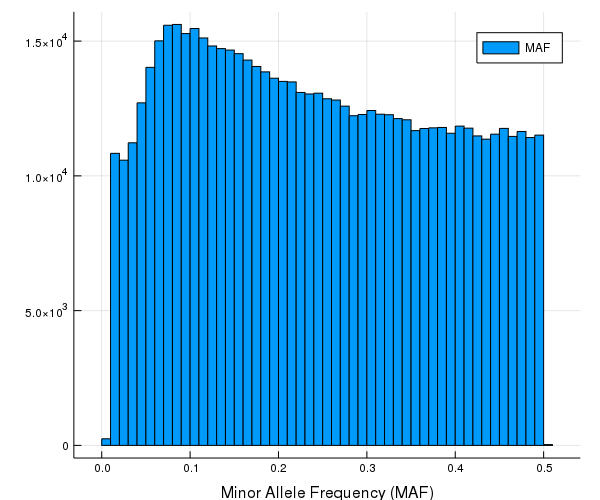

In [15]:
#using Pkg
#pkg "add Plots"
#pkg"add PyPlot"

using Plots
gr(size=(600,500), html_output_format=:png)
histogram(maf_cg10k, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [16]:
# proportion of missing genotypes
sum(missings_by_snp) / length(cg10k)

0.0013128198764010824

In [17]:
# proportion of rare SNPs with maf < 0.05
count(!iszero, maf_cg10k .< 0.05) / length(maf_cg10k)

0.07228069619249913

## Empirical kinship matrix

We estimate empirical kinship based on all SNPs by the genetic relation matrix (GRM). Missing genotypes are imputed on the fly by drawing according to the minor allele frequencies.

In [18]:
## GRM using SNPs with maf > 0.01 (default) (~10 mins on my laptop)
using Random 
Random.seed!(123)
@time Φgrm = grm(cg10k; method = :GRM)

568.176660 seconds (2.91 M allocations: 494.981 MiB, 0.40% gc time)


6670×6670 Array{Float64,2}:
  0.502735      0.00328112   -6.79435e-5   …  -6.09591e-5   -0.00277687 
  0.00328112    0.49807      -0.00195548       0.000884994   0.00341591 
 -6.79435e-5   -0.00195548    0.492348         0.000198191  -0.000337529
  0.00087876   -0.00322605   -0.00192088      -0.00235314   -0.00124267 
 -5.03227e-5   -0.00352498    0.00184588       0.00219109   -0.00163189 
  0.00203199    0.000597697   0.00251237   …   0.00088428    2.21226e-5 
  0.000560862   0.00244517   -0.00183233       0.00120214   -0.00120686 
 -0.000656949   0.00322249   -0.00101472       0.00355832   -0.000240444
 -0.00103874   -0.00125164   -0.000599731      0.00176492    0.00176928 
 -0.00137058    0.00209596    0.000146711     -0.0014453    -0.00103066 
 -0.00209312    0.000140721  -0.000442031  …  -0.000214963  -0.00107391 
  0.000933587   0.00168842    0.00185731      -0.000787908  -0.00311063 
  0.000334572  -0.000886623   0.00304182       0.000752285  -0.00123334 
  ⋮                    

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [20]:
#using Pkg
#pkg"add CSV DataFrames"
#using CSV, DataFrames

cg10k_trait = CSV.File("cg10k_traits.txt"; 
            delim = ' ') |> DataFrame
names!(cg10k_trait, [:FID; :IID; :Trait1; :Trait2; :Trait3; :Trait4; :Trait5; :Trait6; 
             :Trait7; :Trait8; :Trait9; :Trait10; :Trait11; :Trait12; :Trait13])
# do not display FID and IID for privacy
cg10k_trait[:, 3:end]

,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10,Trait11,Trait12,Trait13
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,-1.81573,-0.94615,1.11363,-2.09867,0.744417,0.00139172,0.934732,-1.22677,1.11608,-0.443628,0.824466,-1.02853,-0.394049
2,-1.2444,0.10966,0.467119,-1.62131,1.05668,0.978947,1.00015,0.324874,1.16232,2.69227,3.08264,1.09065,0.0256616
3,1.45567,1.53867,1.09403,0.586655,-0.327965,-0.303377,-0.0334355,-0.464463,-0.33194,-0.486839,-1.10649,-1.42016,-0.687463
4,-0.768809,0.513491,0.244263,-1.3174,1.19394,1.17344,1.08737,0.536023,0.802759,0.234159,0.394175,-0.767366,0.0635386
5,-0.264415,-0.34824,-0.0239065,0.00473916,1.25619,1.20389,1.29801,0.310114,0.62616,0.899289,0.549968,0.540688,0.179675
6,-1.37617,-1.47192,0.29118,-0.803111,-0.26424,-0.260573,-0.165372,-0.219257,1.04702,-0.0985816,0.947393,0.594015,0.245407
7,0.100942,-0.191616,-0.567421,0.378571,-0.246656,-0.608811,0.189081,-1.27078,-0.452476,0.702563,0.332636,0.00269165,0.317117
8,-0.319818,1.35774,0.81869,-1.15566,0.634484,0.291462,0.933324,-0.741083,0.647478,-0.970878,0.220861,0.852512,-0.225905
9,-0.288334,0.566083,0.254958,-0.652578,0.668922,0.978309,0.122863,1.47909,0.0672132,0.0795904,0.167532,0.246916,0.539933


In [21]:
describe(cg10k_trait[:, 3:end])

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Int64,DataType
1,Trait1,0.00221138,-3.20413,0.12501,3.4794,,0,Float64
2,Trait2,0.00135253,-3.51166,0.0335173,4.91342,,0,Float64
3,Trait3,-0.00129591,-3.93844,-0.000782162,7.9163,,0,Float64
4,Trait4,0.00230893,-3.6084,0.228165,3.12769,,0,Float64
5,Trait5,-0.00179039,-4.14875,0.0310343,2.71718,,0,Float64
6,Trait6,-0.00119598,-3.82479,0.036242,2.58973,,0,Float64
7,Trait7,-0.00198906,-4.27246,0.069801,2.65378,,0,Float64
8,Trait8,0.000614075,-5.62549,-0.0386301,5.8057,,0,Float64
9,Trait9,-0.00180965,-5.38197,0.106571,2.57194,,0,Float64


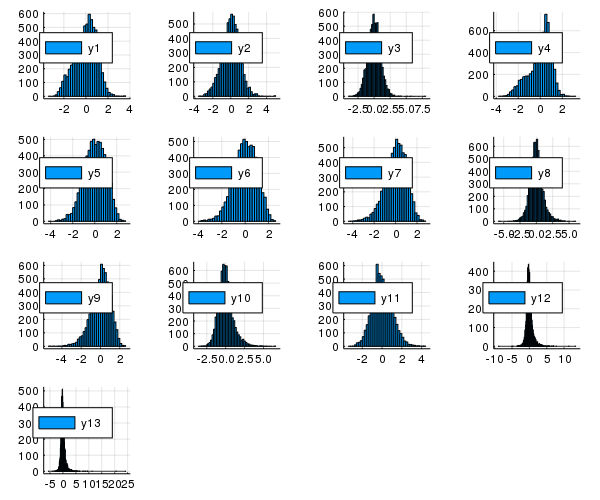

In [22]:
Y = convert(Matrix{Float64}, cg10k_trait[:, 3:15])
histogram(Y, layout = 13)

## Pre-processing data for heritability analysis

To prepare variance component model fitting, we form an instance of `VarianceComponentVariate`. The two variance components are $(2\Phi, I)$.

In [24]:
using VarianceComponentModels, LinearAlgebra

# form data as VarianceComponentVariate
cg10kdata = VarianceComponentVariate(Y, (2Φgrm, Matrix(1.0I, size(Y, 1), size(Y, 1))))
fieldnames(typeof(cg10kdata))

(:Y, :X, :V)

In [25]:
cg10kdata

VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,2},Array{Float64,2}}([-1.81573 -0.94615 … -1.02853 -0.394049; -1.2444 0.10966 … 1.09065 0.0256616; … ; 0.886626 0.487408 … -0.636874 -0.439825; -1.24394 0.213697 … 0.299931 0.392809], Array{Float64}(6670,0), ([1.00547 0.00656224 … -0.000121918 -0.00555374; 0.00656224 0.99614 … 0.00176999 0.00683183; … ; -0.000121918 0.00176999 … 0.998578 0.000962983; -0.00555374 0.00683183 … 0.000962983 0.999599], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]))

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a `TwoVarCompVariateRotate` instance, which is re-used in various variane component estimation procedures.

In [26]:
# pre-compute eigen-decomposition (~50 secs on my laptop)
@time cg10kdata_rotated = TwoVarCompVariateRotate(cg10kdata)
fieldnames(typeof(cg10kdata_rotated))

 49.812646 seconds (1.74 M allocations: 1.080 GiB, 0.33% gc time)


(:Yrot, :Xrot, :eigval, :eigvec, :logdetV2)

## Save intermediate results

We don't want to re-compute SnpArray and empirical kinship matrices again and again for heritibility analysis.

To load workspace

In [40]:
#pkg"add FileIO JLD2"

using JLD2
@save "cg10k.jld2"
varinfo()

| name              |         size | summary                                                                                |
|:----------------- | ------------:|:-------------------------------------------------------------------------------------- |
| Base              |              | Module                                                                                 |
| Core              |              | Module                                                                                 |
| Main              |              | Module                                                                                 |
| Plots             |    2.988 MiB | Module                                                                                 |
| PyPlot            |  782.799 KiB | Module                                                                                 |
| Y                 |  677.461 KiB | 6670×13 Array{Float64,2}                                                               |
| cg10k             | 1022.983 MiB | 6670×630860 SnpArray                                                                   |
| cg10k_trait       |    1.605 MiB | 6670×15 DataFrame                                                                      |
| cg10kdata         |  679.508 MiB | VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,2},Array{Float64,2}} |
| cg10kdata_rotated |  340.136 MiB | TwoVarCompVariateRotate{Float64,Array{Float64,2},Array{Float64,2}}                     |
| maf_cg10k         |    4.813 MiB | 630860-element Array{Float64,1}                                                        |
| missings_by_snp   |    4.813 MiB | 1×630860 Array{Int64,2}                                                                |
| mp                |   28.748 MiB | 6670×630860 SparseArrays.SparseMatrixCSC{Bool,Int32}                                   |
| people            |      8 bytes | Int64                                                                                  |
| snps              |      8 bytes | Int64                                                                                  |
| startupfile       |     57 bytes | String                                                                                 |
| Φgrm              |  339.423 MiB | 6670×6670 Array{Float64,2}                                                             |


In [45]:
using SnpArrays, JLD2, DataFrames, VarianceComponentModels, Plots
pyplot()

@load "cg10k.jld2"
varinfo()

┌ Warning: type SparseArrays.SparseMatrixCSC{Bool,Int32} does not exist in workspace; reconstructing
└ @ JLD2 /Users/juhyun-kim/.julia/packages/JLD2/KjBIK/src/data.jl:1153


| name              |         size | summary                                                                                     |
|:----------------- | ------------:|:------------------------------------------------------------------------------------------- |
| Base              |              | Module                                                                                      |
| Core              |              | Module                                                                                      |
| Main              |              | Module                                                                                      |
| Plots             |    2.988 MiB | Module                                                                                      |
| PyPlot            |  782.799 KiB | Module                                                                                      |
| Y                 |  677.461 KiB | 6670×13 Array{Float64,2}                                                                    |
| cg10k             | 1022.983 MiB | 6670×630860 SnpArray                                                                        |
| cg10k_trait       |    1.605 MiB | 6670×15 DataFrame                                                                           |
| cg10kdata         |  679.508 MiB | VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,2},Array{Float64,2}}      |
| cg10kdata_rotated |  340.136 MiB | TwoVarCompVariateRotate{Float64,Array{Float64,2},Array{Float64,2}}                          |
| maf_cg10k         |    4.813 MiB | 630860-element Array{Float64,1}                                                             |
| missings_by_snp   |    4.813 MiB | 1×630860 Array{Int64,2}                                                                     |
| mp                |   28.748 MiB | getfield(JLD2.ReconstructedTypes, Symbol("##SparseArrays.SparseMatrixCSC{Bool,Int32}#386")) |
| people            |      8 bytes | Int64                                                                                       |
| snps              |      8 bytes | Int64                                                                                       |
| startupfile       |     57 bytes | String                                                                                      |
| Φgrm              |  339.423 MiB | 6670×6670 Array{Float64,2}                                                                  |


## Heritability of single traits

We use Fisher scoring algorithm to fit variance component model for each single trait.

In [46]:
# heritability from single trait analysis
hST = zeros(13)
# standard errors of estimated heritability
hST_se = zeros(13)
# additive genetic effects
σ2a = zeros(13)
# enviromental effects
σ2e = zeros(13)

@time for trait in 1:13
    println(names(cg10k_trait)[trait + 2])
    # form data set for trait j
    traitj_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, trait], cg10kdata_rotated.Xrot, 
        cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
    # initialize model parameters
    traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
    _, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
    σ2a[trait] = traitj_model.Σ[1][1]
    σ2e[trait] = traitj_model.Σ[2][1]
    @show σ2a[trait], σ2e[trait]
    h, hse = heritability(traitj_model.Σ, Σcov)
    hST[trait] = h[1]
    hST_se[trait] = hse[1]
end

Trait1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

(σ2a[trait], σ2e[trait]) = (0.2594760477653529, 0.7375938878381831)
Trait2
(σ2a[trait], σ2e[trait]) = (0.18588150448760332, 0.8137880281704619)
Trait3
(σ2a[trait], σ2e[trait]) = (0.31960937565352526, 0.6795300238388766)
Trait4
(σ2a[trait], σ2e[trait]) = (0.26578244697498915, 0.7304994606945259)
Trait5
(σ2a[trait], σ2e[trait]) = (0.28143198005767217, 0.7169747061764987)
Trait6
(σ2a[trait], σ2e[trait]) = (0.2830055131241748, 0.7168800753377107)
Trait7
(σ2a[trait], σ2e[trait]) = (0.2156542141311619, 0.7816910320891676)
Trait8
(σ2a[trait], σ2e[trait]) = (0.19408878271207824, 0.8058201577783562)
Trait9


In [47]:
# heritability and standard errors
[hST'; hST_se']

2×13 Array{Float64,2}:
 0.260239   0.185943  0.319885   …  0.164757   0.0823403  0.0569176
 0.0799434  0.08689   0.0739664     0.0887138  0.0944375  0.0953072

## Pairwise traits

Joint analysis of multiple traits is subject to intensive research recently. Following code snippet does joint analysis of all pairs of traits, a total of 78 bivariate variane component models.

In [49]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa = Array{Matrix{Float64}}(undef, 13, 13)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe = Array{Matrix{Float64}}(undef, 13, 13)


@time for i in 1:13
    for j in (i+1):13
        println(names(cg10k_trait)[i + 2], names(cg10k_trait)[j + 2])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, [i;j]], cg10kdata_rotated.Xrot, 
            cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=false)
        Σa[i, j] = traitij_model.Σ[1]
        Σe[i, j] = traitij_model.Σ[2]
        @show Σa[i, j], Σe[i, j]
    end
end

Trait1Trait2
(Σa[i, j], Σe[i, j]) = ([0.258529 0.173943; 0.173943 0.184525], [0.738519 0.58639; 0.58639 0.815122])
Trait1Trait3
(Σa[i, j], Σe[i, j]) = ([0.259934 -0.0139395; -0.0139395 0.320025], [0.737149 -0.120342; -0.120342 0.67913])
Trait1Trait4
(Σa[i, j], Σe[i, j]) = ([0.259307 0.222267; 0.222267 0.265791], [0.737759 0.600077; 0.600077 0.730492])
Trait1Trait5
(Σa[i, j], Σe[i, j]) = ([0.259264 -0.147125; -0.147125 0.282102], [0.737798 -0.254669; -0.254669 0.716327])
Trait1Trait6
(Σa[i, j], Σe[i, j]) = ([0.259171 -0.129519; -0.129519 0.283267], [0.73789 -0.231373; -0.231373 0.716628])
Trait1Trait7
(Σa[i, j], Σe[i, j]) = ([0.258784 -0.140357; -0.140357 0.21535], [0.738269 -0.197894; -0.197894 0.782002])
Trait1Trait8
(Σa[i, j], Σe[i, j]) = ([0.259467 -0.0336174; -0.0336174 0.194107], [0.737603 -0.12623; -0.12623 0.805802])
Trait1Trait9
(Σa[i, j], Σe[i, j]) = ([0.261524 -0.204467; -0.204467 0.246378], [0.735632 -0.308118; -0.308118 0.752288])
Trait1Trait10
(Σa[i, j], Σe[i, j]) = ([0.25

(Σa[i, j], Σe[i, j]) = ([0.247395 0.0305136; 0.0305136 0.164575], [0.751288 0.153633; 0.153633 0.834308])
Trait9Trait12
(Σa[i, j], Σe[i, j]) = ([0.249928 0.0844216; 0.0844216 0.0880992], [0.748829 0.108018; 0.108018 0.910884])
Trait9Trait13
(Σa[i, j], Σe[i, j]) = ([0.248998 0.0925603; 0.0925603 0.0580327], [0.749747 0.0992651; 0.0992651 0.94131])
Trait10Trait11
(Σa[i, j], Σe[i, j]) = ([0.0923059 0.0990858; 0.0990858 0.164638], [0.907657 0.475503; 0.475503 0.834248])
Trait10Trait12
(Σa[i, j], Σe[i, j]) = ([0.0957712 0.0574496; 0.0574496 0.0785646], [0.904228 0.0843534; 0.0843534 0.920326])
Trait10Trait13
(Σa[i, j], Σe[i, j]) = ([0.100109 -0.0266483; -0.0266483 0.0578511], [0.899941 0.164674; 0.164674 0.941451])
Trait11Trait12
(Σa[i, j], Σe[i, j]) = ([0.163544 0.0571549; 0.0571549 0.0784378], [0.835325 0.145549; 0.145549 0.920432])
Trait11Trait13
(Σa[i, j], Σe[i, j]) = ([0.164571 -0.00169939; -0.00169939 0.0575331], [0.834326 0.200725; 0.200725 0.941755])
Trait12Trait13
(Σa[i, j], Σe[i, 

## 3-trait analysis

Researchers want to jointly analyze traits 5-7. Our strategy is to try both Fisher scoring and MM algorithm with different starting point, and choose the best local optimum. We first form the data set and run Fisher scoring, which yields a final objective value -1.4700991+04.

In [50]:
traitidx = 5:7
# form data set
trait57_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, traitidx], cg10kdata_rotated.Xrot, 
    cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
# initialize model parameters
trait57_model = VarianceComponentModel(trait57_data)
# estimate variance components
@time mle_fs!(trait57_model, trait57_data; solver=:Ipopt, verbose=true)
trait57_model

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       78

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,3), ([0.28137 0.280153 0.232512; 0.280153 0.284916 0.220363; 0.232512 0.220363 0.212921], [0.717042 0.661484 0.674207; 0.661484 0.714964 0.581648; 0.674207 0.581648 0.784373]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf)

We then run the MM algorithm, starting from the Fisher scoring answer. MM finds an improved solution with objective value 8.955397e+03.

In [51]:
# trait59_model contains the fitted model by Fisher scoring now
@time mle_mm!(trait57_model, trait57_data; verbose=true)
trait57_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.470095e+04
       1  -1.470095e+04

  0.505115 seconds (1.01 M allocations: 50.370 MiB, 5.09% gc time)


VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,3), ([0.28137 0.280153 0.232512; 0.280153 0.284916 0.220363; 0.232512 0.220363 0.212921], [0.717042 0.661484 0.674207; 0.661484 0.714964 0.581648; 0.674207 0.581648 0.784373]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf)

Do another run of MM algorithm from default starting point. It leads to a slightly better local optimum -1.470104e+04, slighly worse than the Fisher scoring result. Follow up anlaysis should use the Fisher scoring result.

In [52]:
# default starting point
trait57_model = VarianceComponentModel(trait57_data)
@time _, _, _, Σcov, = mle_mm!(trait57_model, trait57_data; verbose=true)
trait57_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -3.024417e+04
       1  -2.040172e+04
       2  -1.656053e+04
       3  -1.528554e+04
       4  -1.491023e+04
       5  -1.480677e+04
       6  -1.477849e+04
       7  -1.477005e+04
       8  -1.476675e+04
       9  -1.476478e+04
      10  -1.476318e+04
      20  -1.475020e+04
      30  -1.474023e+04
      40  -1.473255e+04
      50  -1.472662e+04
      60  -1.472201e+04
      70  -1.471839e+04
      80  -1.471554e+04
      90  -1.471326e+04
     100  -1.471142e+04
     110  -1.470993e+04
     120  -1.470871e+04
     130  -1.470770e+04
     140  -1.470686e+04
     150  -1.470616e+04
     160  -1.470557e+04
     170  -1.470506e+04
     180  -1.470463e+04
     190  -1.470426e+04
     200  -1.470394e+04
     210  -1.470366e+04
     220  -1.470342e+04
     230  -1.470321e+04
     240  -1.470302e+04
     250  -1.470285e+04
     260  -1.470270e+04
     270  -1.470257e+04
     280  -1.470245e+04
     290  -1.470234e+

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,3), ([0.281394 0.280169 0.232564; 0.280169 0.285001 0.220511; 0.232564 0.220511 0.213147], [0.717018 0.661467 0.674155; 0.661467 0.714877 0.581502; 0.674155 0.581502 0.784149]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf)

Heritability from 3-variate estimate and their standard errors.

In [53]:
h, hse = heritability(trait57_model.Σ, Σcov)
[h'; hse']

2×3 Array{Float64,2}:
 0.281842   0.285036   0.213725 
 0.0777056  0.0772501  0.0840114

## 13-trait joint analysis

In some situations, such as studying the genetic covariance, we need to jointly analyze 13 traits. We first try the **Fisher scoring algorithm**.

In [54]:
# initialize model parameters
traitall_model = VarianceComponentModel(cg10kdata_rotated)
# estimate variance components using Fisher scoring algorithm
@time mle_fs!(traitall_model, cg10kdata_rotated; solver=:Ipopt, verbose=true)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

From the output we can see the Fisher scoring algorithm ran into some numerical issues. Let's try the **MM algorithm**.

In [55]:
# reset model parameters
traitall_model = VarianceComponentModel(cg10kdata_rotated)
# estimate variance components using Fisher scoring algorithm
@time mle_mm!(traitall_model, cg10kdata_rotated; verbose=true)


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.311198e+05
       1  -8.001595e+04
       2  -5.806836e+04
       3  -4.926167e+04
       4  -4.611163e+04
       5  -4.511722e+04
       6  -4.482795e+04
       7  -4.474405e+04
       8  -4.471603e+04
       9  -4.470277e+04
      10  -4.469345e+04
      20  -4.462308e+04
      30  -4.456930e+04
      40  -4.452802e+04
      50  -4.449620e+04
      60  -4.447148e+04
      70  -4.445209e+04
      80  -4.443672e+04
      90  -4.442442e+04
     100  -4.441448e+04
     110  -4.440635e+04
     120  -4.439966e+04
     130  -4.439409e+04
     140  -4.438943e+04
     150  -4.438549e+04
     160  -4.438215e+04
     170  -4.437928e+04
     180  -4.437682e+04
     190  -4.437469e+04
     200  -4.437283e+04
     210  -4.437121e+04
     220  -4.436978e+04
     230  -4.436853e+04
     240  -4.436742e+04
     250  -4.436643e+04
     260  -4.436555e+04
     270  -4.436476e+04
     280  -4.436406e+04
     290  -4.436342e+

(-44356.24416259489, VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,13), ([0.272112 0.190023 … -0.128464 -0.0976418; 0.190023 0.216814 … -0.0687833 -0.04341; … ; -0.128464 -0.0687833 … 0.116994 0.0900933; -0.0976418 -0.04341 … 0.0900933 0.105876], [0.725183 0.570497 … -0.0589748 -0.125486; 0.570497 0.783023 … 0.0235685 0.0464638; … ; -0.0589748 0.0235685 … 0.882056 0.551829; -0.125486 0.0464638 … 0.551829 0.893642]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf), ([0.0111603 0.013107 … 0.0128915 0.0127587; 0.0131027 0.0151631 … 0.017153 0.0171359; … ; 0.0128908 0.017153 … 0.0174176 0.018212; 0.0127586 0.0171361 … 0.0182122 0.0188002], [0.0112235 0.0133041 … 0.0130038 0.0127778; 0.0133005 0.0158053 … 0.0178518 0.0177823; … ; 0.0130043 0.0178518 … 0.0179557 0.0187638; 0.0127775 0.0177823 … 0.0187637 0.0193477]), [0.000124552 7.23469e-5 … -3.6584e-7 -1.40474e-5; 7.23585e-5 0.00017168 … -2.04611e-5 -3.18804e-6; … ; -3.70686e-7 -2.04634e-5 … 0.0003

It converges after ~1000 iterations.

## Save analysis results

In [ ]:
#using JLD2, FileIO
#save("copd.jld2")
#varinfo()